<a href="https://colab.research.google.com/github/m-mejiap/TopicosAvanzadosEnAnalitica/blob/main/Ejercicios%20Grafos/E10-TwitterNetworkAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Network Analysis
This notebook contains a social network analysis mainly executed with the library of NetworkX. In detail, this dataset consists of 'circles' (or 'lists') from Twitter. Twitter data was crawled from public sources. The dataset includes node features (profiles), circles, and ego networks. The dataset can be found at this link: [Stanford Twitter Dataset](https://snap.stanford.edu/data/ego-Twitter.html).

## Import packages

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import community
from community import community_louvain

%matplotlib inline

## Analysis
The edges are loaded from the `data` folder and saved in a dataframe. Each edge is a new row and for each edge there is a `start_node` and an `end_node` column

In [ ]:
twitter = pd.read_csv(
    "https://snap.stanford.edu/data/twitter_combined.txt.gz",
    compression="gzip",
    sep=" ",
    names=["start_node", "end_node"],
)
twitter = twitter.iloc[:80000]

The graph is created from the `twitter` dataframe of the edges:

In [ ]:
G = nx.from_pandas_edgelist(twitter, "start_node", "end_node")

## Visualizing the graph

Let's start our exploration by visualizing the graph. Visualization plays a
central role in exploratory data analysis to help get a qualitative feel for
the data.

Since we don't have any real sense of structure in the data, let's start by
viewing the graph with `random_layout`, which is among the fastest of the layout
functions.

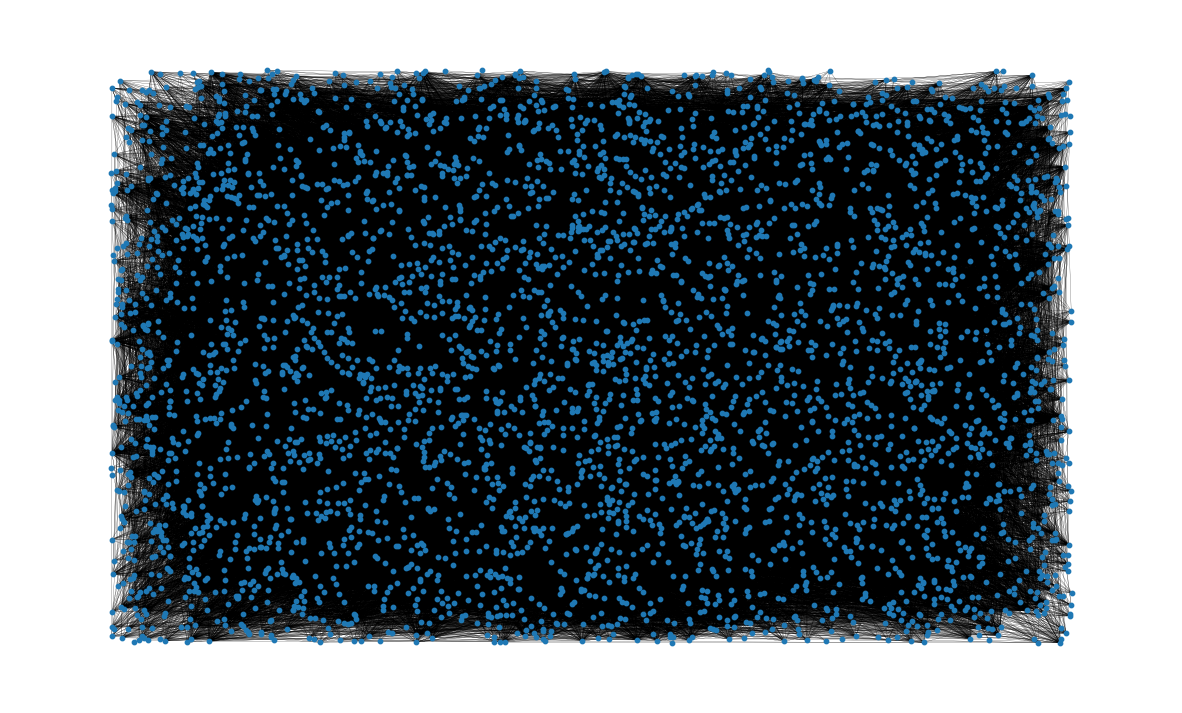

In [ ]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)

Do we need more or less information (nodes or edges) from the graph to do the analysis? Let's check `spring_layout` and continue analysis...

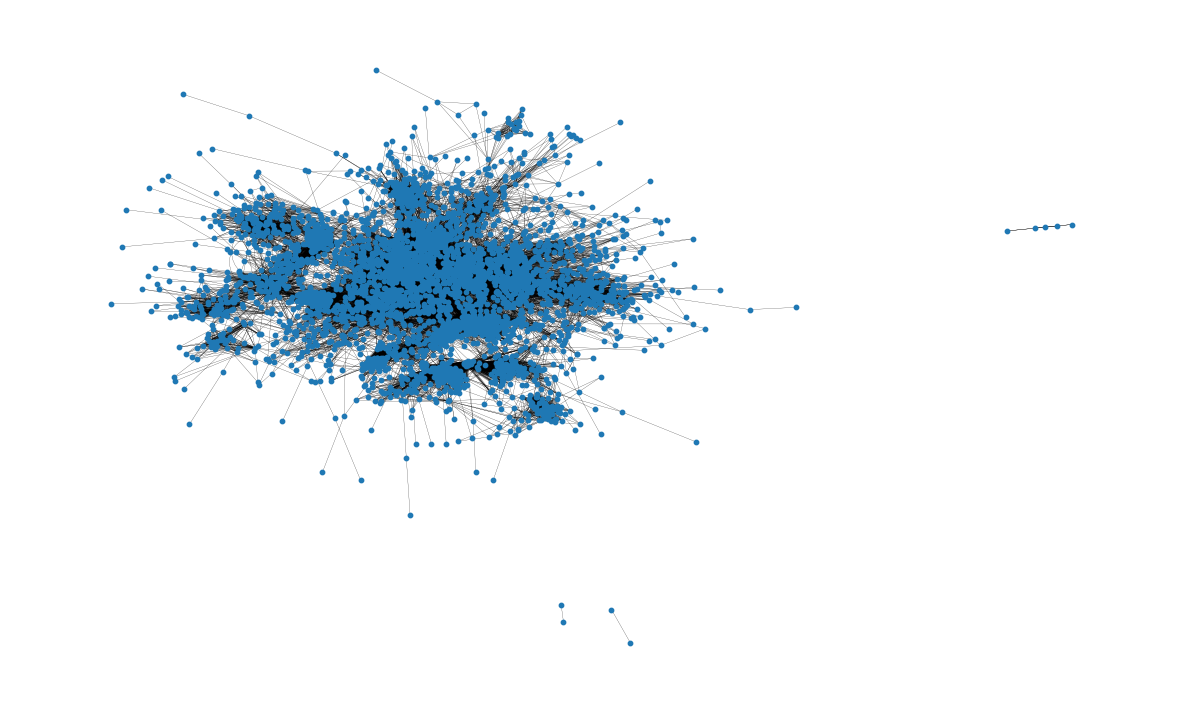

In [ ]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

What other information can we extract from this network? ... (check graphs metrics)

## Información general del grafo

In [ ]:
print('Number of nodes:', len(G.nodes))
print('Number of edges:', len(G.edges))
print('Average degree:', sum(dict(G.degree).values()) / len(G.nodes))
print(G)  # to get the graph properties

Number of nodes: 4316
Number of edges: 58270
Average degree: 27.00185356811863
Graph with 4316 nodes and 58270 edges


In [ ]:
#Shortest path lenght of all nodes
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))
average_path_lengths = [
    np.mean(list(spl.values())) for spl in shortest_path_lengths.values()
]
print('El camino promedio más corto del grafo es',np.mean(average_path_lengths))
#Densidad
print('la densidad del grafo es',nx.density(G))
#Coeficiente de agrupamiento
print('el coeficiente de agrupamiento del grafo es',nx.average_clustering(G))
#Transitividad
print('la transividad del grafo es', nx.transitivity(G))

El camino promedio más corto del grafo es 4.837700405033223
la densidad del grafo es 0.0062576717423218145
el coeficiente de agrupamiento del grafo es 0.4949716847236492
la transividad del grafo es 0.4117694383246281


Text(0, 0.5, 'Counts')

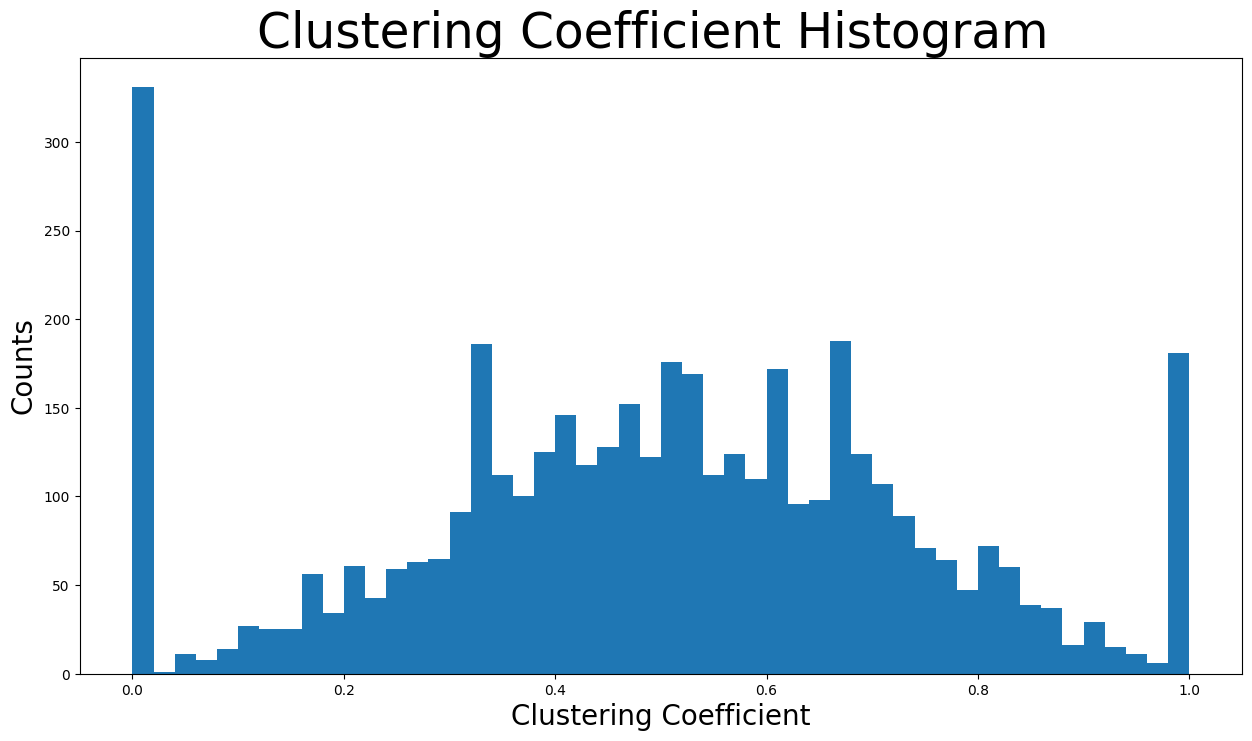

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(nx.clustering(G).values(), bins=50)
plt.title("Clustering Coefficient Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Clustering Coefficient", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

Los resultados de las medidas anteriores demuestran lo siguiente:
1. Para llegar de un nodo a otro se atravesarán en promedio 4.8 aristas
2. El grafo de la red de twitter no se encuentra altamente interconectada (baja densidad),  es decir hay menos relaciones o interacciones entre individuos en la red. Esto podría deberse a varios factores: como comunicación limitada, conexiones escasas o una gran cantidad de individuos o grupos aislados dentro de la red.
3. En promedio los nodos del grafo están moderadamente agrupados, es decir, tienden a formar clusters o grupos de nodos interconectados pero el clustering no es extremadamente alto.
4. Hay nivel moderado de agrupamiento o cierre en la red de twitter, es decir, si hay tendencia a formar comunidades o grupos.(amigos de amigos a ser amigos ellos mismos)

## Medidas de centralidad

### Grado de centralidad

Text(0, 0.5, 'Counts')

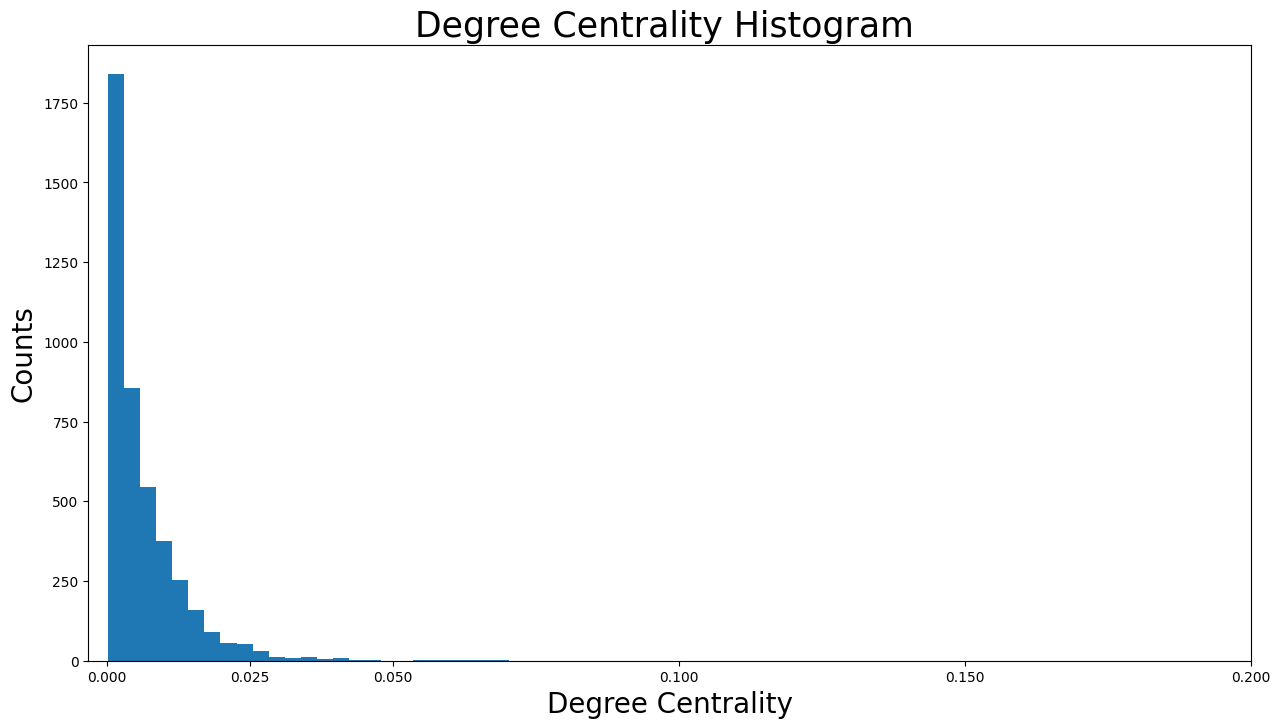

In [ ]:
deg_cen = nx.degree_centrality(G)
plt.figure(figsize=(15, 8))
plt.hist(deg_cen.values(), bins=25)
plt.xticks(ticks=[0, 0.025, 0.05, 0.1, 0.15, 0.2])  # set the x axis ticks
plt.title("Degree Centrality Histogram ", fontdict={"size": 25}, loc="center")
plt.xlabel("Degree Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

El grado de centralidad de los nodos que conforman la red de Twitter evidencia asimetría derecha, es decir que el mayor numero de nodos se concentran en grados de centralidad entre 0 y 0.025

In [ ]:
#Los 5 nodos con mayor grado de centralidad y su numero de vecinos
(sorted(G.degree, key=lambda item: item[1], reverse=True))[:5]

[(48485771, 303),
 (5442012, 294),
 (3359851, 284),
 (40981798, 270),
 (43003845, 256)]

En el hisograma anterior se evidenció que la mayor concentración de los nodos se encontraban con menores grados de centralidad. Esto se confirma al identificar los 5 nodos con mayor grado que no superan el 10% y en donde se destaca el usurio 48485771 de twitter que es amigo de alrededor del 7% del total de la red con un total de 303 amigos en twitter.

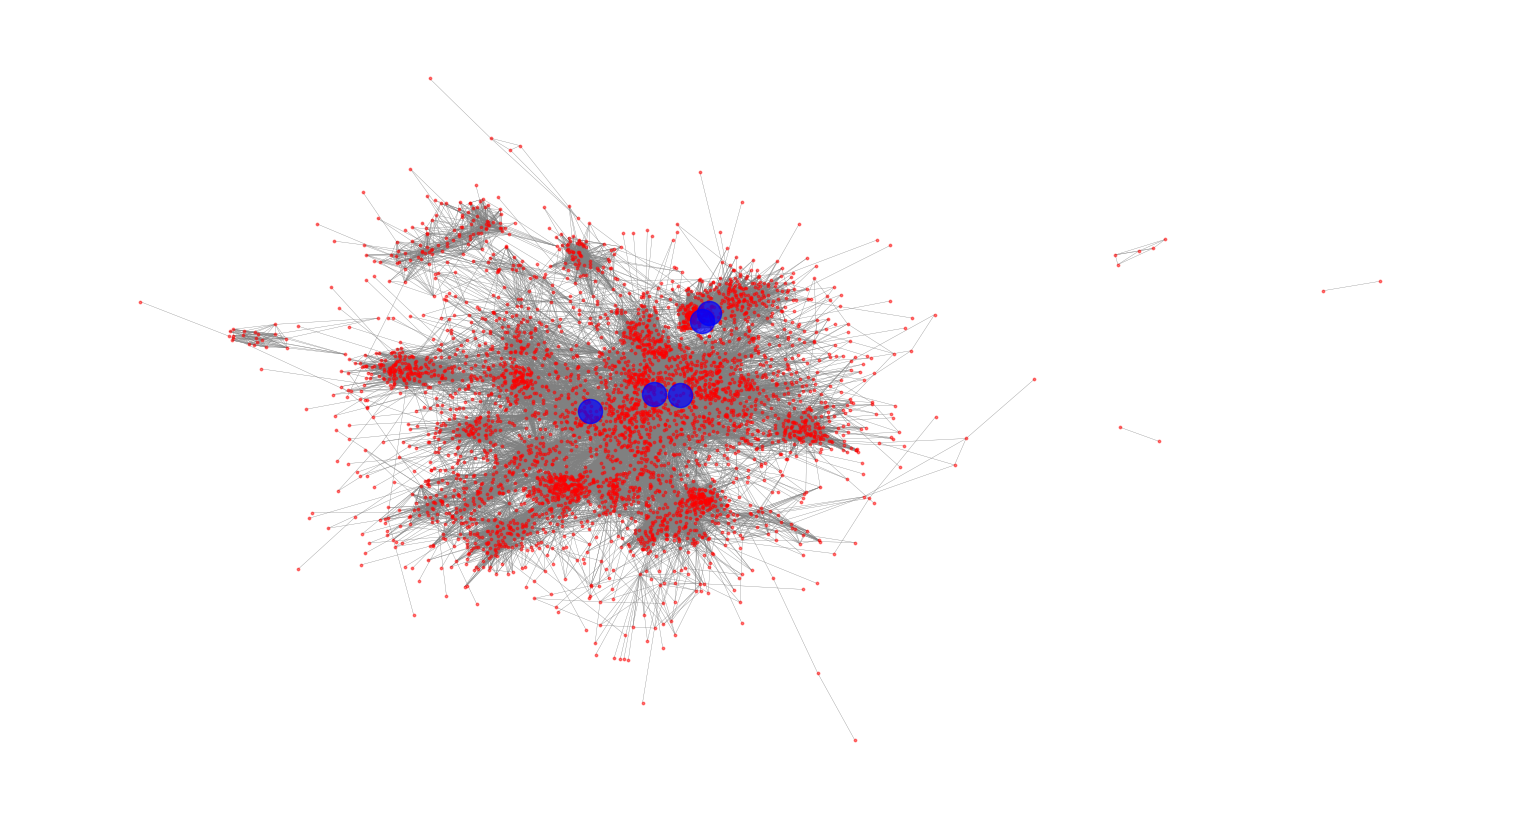

In [ ]:
#Identificando nodos mas importantes
dict_items = deg_cen.items()
dict_items_sorted = sorted(dict_items, key = lambda item:item[1], reverse = True)
degree_cnt_sorted = {k:v for k,v in dict_items_sorted}
most_important_nodes = list(degree_cnt_sorted)[:5]
#Grafico destacando los nodos mas importantes
layout = nx.spring_layout(G,iterations=15, seed=12)
plt.figure(figsize=(15, 8))
nx.draw(G, pos = layout, node_color = "red", node_size = 3, edge_color= "gray", width=0.2,alpha = 0.5)
nx.draw(G, pos = layout, nodelist = most_important_nodes, node_color = "blue", edge_color= "gray",width=0.2, alpha = 0.7)

### Grado de cercanía

closenness centrality {214328887: 0.13861646400585553, 34428380: 0.16070231749241962, 17116707: 0.13855366730833404, 28465635: 0.1390673675089176, 380580781: 0.13829342737669406, 18996905: 0.13902846482551065, 221036078: 0.13827418922862747, 153460275: 0.13821170219626494, 107830991: 0.13857298330823764, 17868918: 0.1390236035204012, 151338729: 0.13880035039552988, 222261763: 0.13852952987979353, 19705747: 0.13862613008890742, 88323281: 0.1387761269486895, 19933035: 0.13852952987979353, 149538028: 0.13854401132761704, 158419434: 0.13872770541102422, 17434613: 0.13831748259105772, 153226312: 0.13875675427793516, 364971269: 0.13851987726300224, 100581193: 0.13895072471796863, 279787626: 0.13909655881192112, 113058991: 0.13868899250313776, 69592091: 0.13887792228439533, 187773078: 0.15945841169005992, 406628822: 0.13847163434959614, 262802533: 0.13817807871967586, 460282402: 0.13818768375781848, 280935165: 0.13851505145902848, 437804658: 0.13811088082117387, 27633075: 0.1390090216446386, 

Text(0, 0.5, 'Counts')

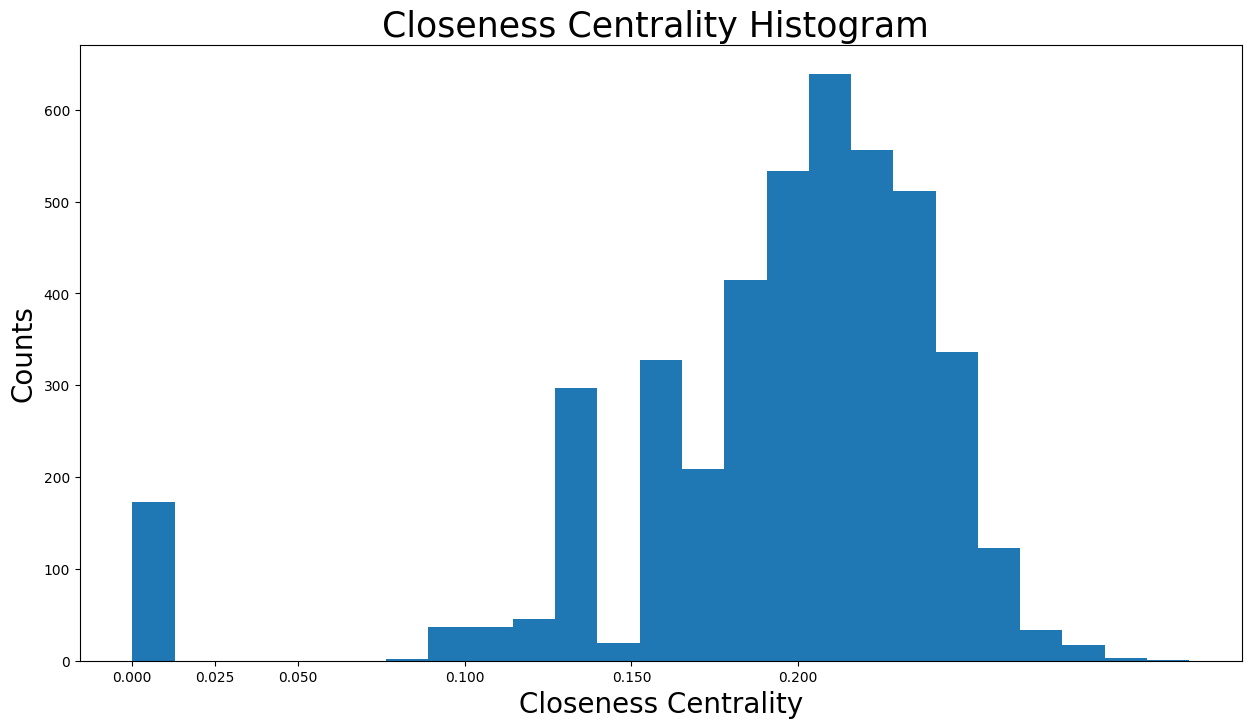

In [ ]:
clos_cen = nx.closeness_centrality(G)
print('closenness centrality', clos_cen)
plt.figure(figsize=(15, 8))
plt.hist(clos_cen.values(), bins=25)
plt.xticks(ticks=[0, 0.025, 0.05, 0.1, 0.15, 0.2])
plt.title("Closeness Centrality Histogram ", fontdict={"size": 25}, loc="center")
plt.xlabel("Closeness Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

(-0.7944864898920059,
 1.1705168157815933,
 -0.7201921084523202,
 0.7234124878048898)

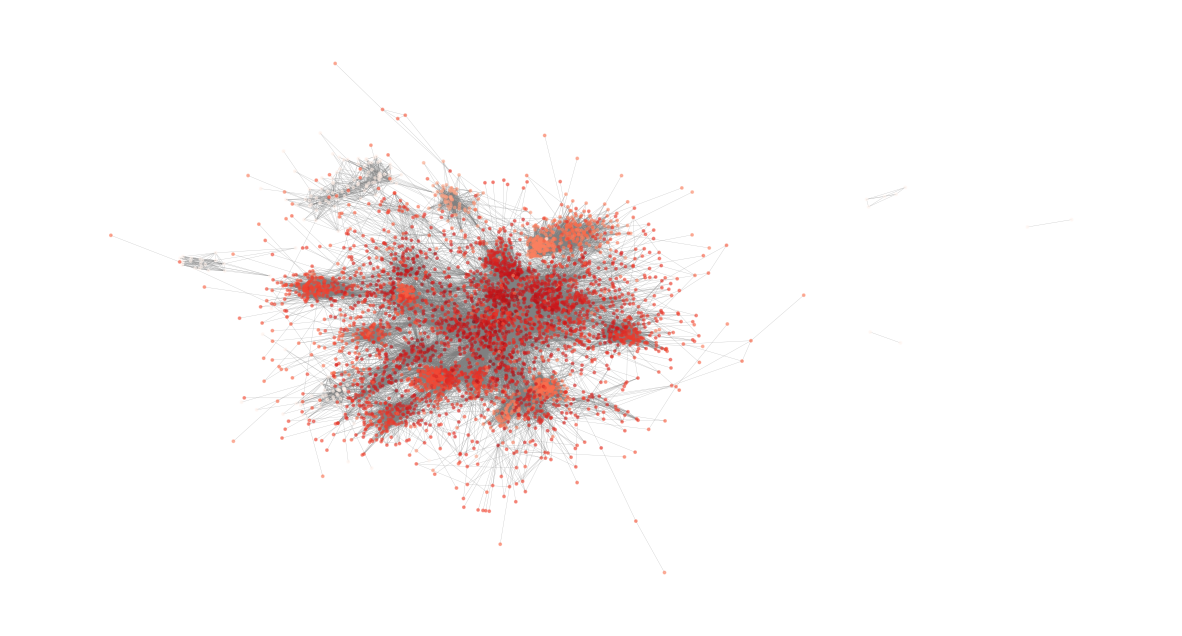

In [ ]:
values =[clos_cen.get(node)*100 for node in G.nodes()]
pos = nx.spring_layout(G,iterations=15, seed=12)
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, cmap=plt.get_cmap('Reds'), node_color=values,
                 node_size=3,with_labels=False,edge_color="gray",width=0.2,alpha = 0.5)
plt.axis('off')

Se observa que los valores de grado de cercanía en la red oscilan entre 0 y 0.30, es decir que los nodos de la red estan relativamente distantes y puede que existan usuarios que se encuentran desconectados de la misma.
El mayor numero de usuarios se concentran con grados de cercanía entre 0.15 y 0.25.Sin emabrgo, se observan algunos grupos de amigos de twitter (comunidades) que se encuentran más alejados con grados de cercanía entre 0 y 0.10

[(3359851, 0.3174907000782523),
 (15234657, 0.2989200839846593),
 (48485771, 0.2947102540271258),
 (7860742, 0.293730499193259),
 (15666380, 0.2907448655999966)]

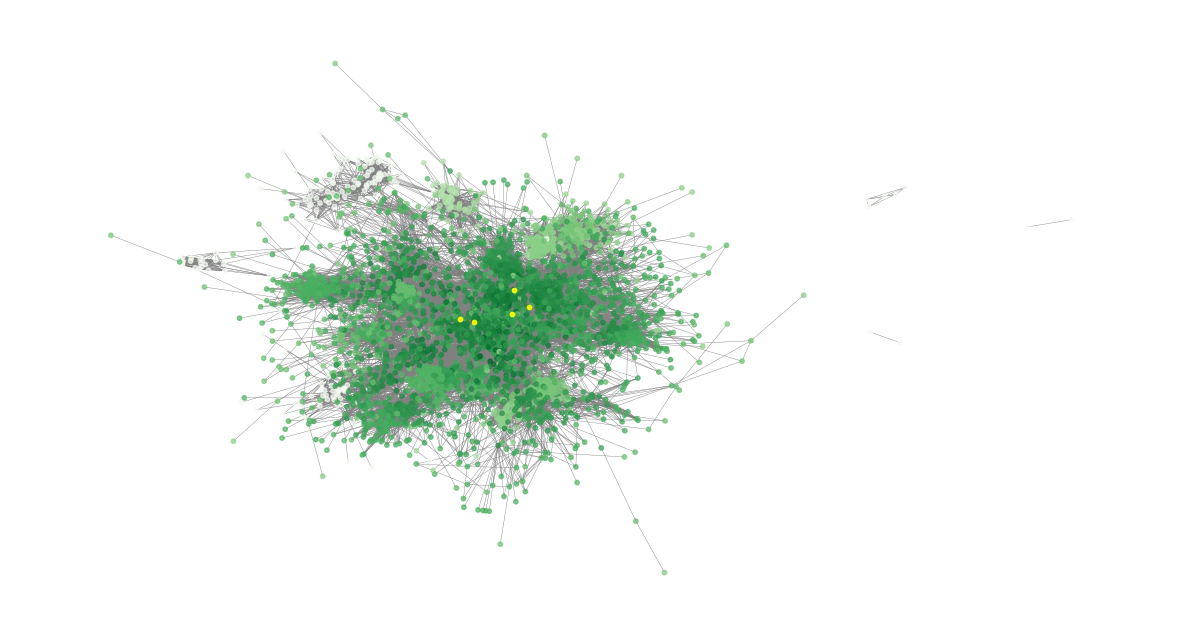

In [ ]:
#Identificando nodos mas cercanos
clos_items = clos_cen.items()
clos_items_sorted = sorted(clos_items, key = lambda item:item[1], reverse = True)
clos_cnt_sorted = {k:v for k,v in clos_items_sorted}
close_important_nodes = list(clos_cnt_sorted)[:5]
#Grafico de nodos con mayor grado de cercanía
pos = nx.spring_layout(G,iterations=15, seed=12)
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, cmap=plt.get_cmap('Greens'), with_labels=False,
                 width=0.2,edge_color="gray",node_color=values,node_size=10,alpha = 0.7)
nx.draw_networkx(G, pos=pos, nodelist = close_important_nodes, with_labels=False,
                 width=0.2,edge_color="gray",node_color="yellow",node_size=10,alpha = 0.9)
plt.axis('off')
sorted(clos_cen.items(), key=lambda x:x[1], reverse=True)[0:5]

Se identificaron 5 usuarios de twitter con mayor grado de cercanía, siendo estas las personas que pueden tener una mayor capacidad para difundir información o ejercer influencia debido a su proximidad a otros usuarios. Se destacan los nodos **3359851** y **48485771** con una mayor importancia porque tambien registraron altos grados de centralidad, tienen mayor numero de conexiones en la red y en promedio tienen mayor cercanía a otros usuarios de la red.

### Betweenness Centrality

betweenness centrality {214328887: 0.13861646400585553, 34428380: 0.16070231749241962, 17116707: 0.13855366730833404, 28465635: 0.1390673675089176, 380580781: 0.13829342737669406, 18996905: 0.13902846482551065, 221036078: 0.13827418922862747, 153460275: 0.13821170219626494, 107830991: 0.13857298330823764, 17868918: 0.1390236035204012, 151338729: 0.13880035039552988, 222261763: 0.13852952987979353, 19705747: 0.13862613008890742, 88323281: 0.1387761269486895, 19933035: 0.13852952987979353, 149538028: 0.13854401132761704, 158419434: 0.13872770541102422, 17434613: 0.13831748259105772, 153226312: 0.13875675427793516, 364971269: 0.13851987726300224, 100581193: 0.13895072471796863, 279787626: 0.13909655881192112, 113058991: 0.13868899250313776, 69592091: 0.13887792228439533, 187773078: 0.15945841169005992, 406628822: 0.13847163434959614, 262802533: 0.13817807871967586, 460282402: 0.13818768375781848, 280935165: 0.13851505145902848, 437804658: 0.13811088082117387, 27633075: 0.1390090216446386,

Text(0, 0.5, 'Counts')

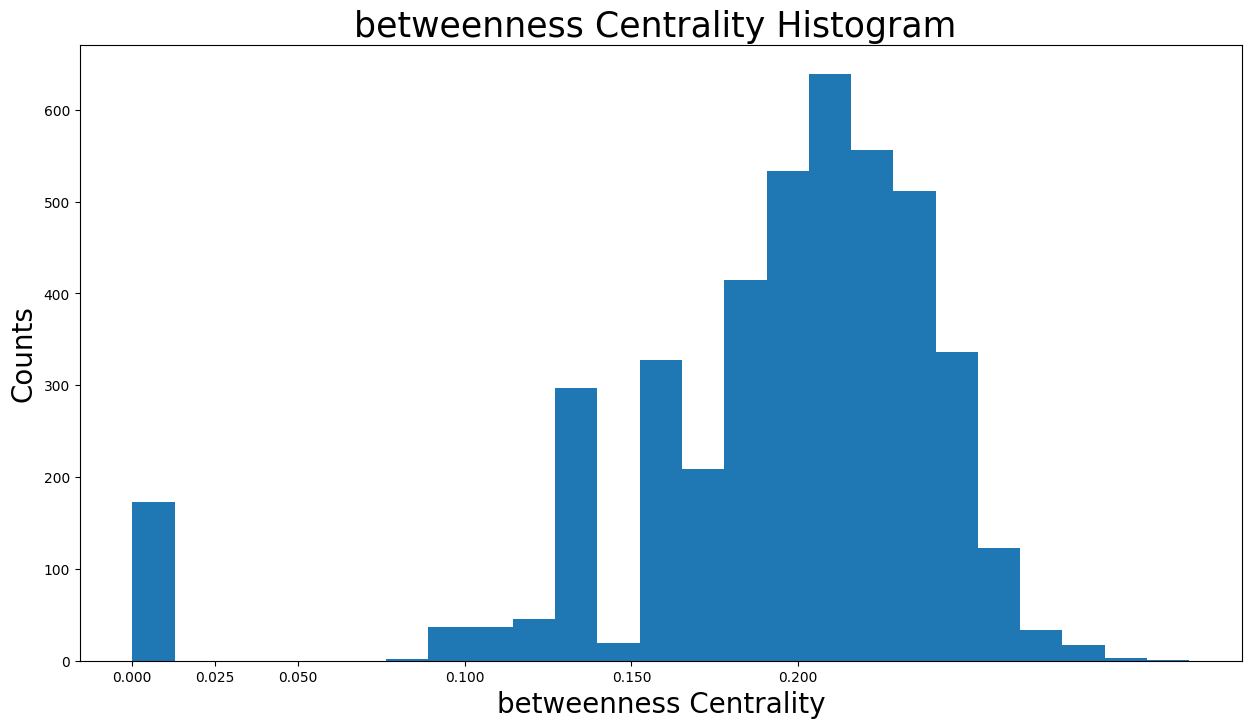

In [ ]:
bet_cen = nx.betweenness_centrality(G)
print('betweenness centrality', clos_cen)
plt.figure(figsize=(15, 8))
plt.hist(clos_cen.values(), bins=25)
plt.xticks(ticks=[0, 0.025, 0.05, 0.1, 0.15, 0.2])
plt.title("betweenness Centrality Histogram ", fontdict={"size": 25}, loc="center")
plt.xlabel("betweenness Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

(-0.7944864898920059,
 1.1705168157815933,
 -0.7201921084523202,
 0.7234124878048898)

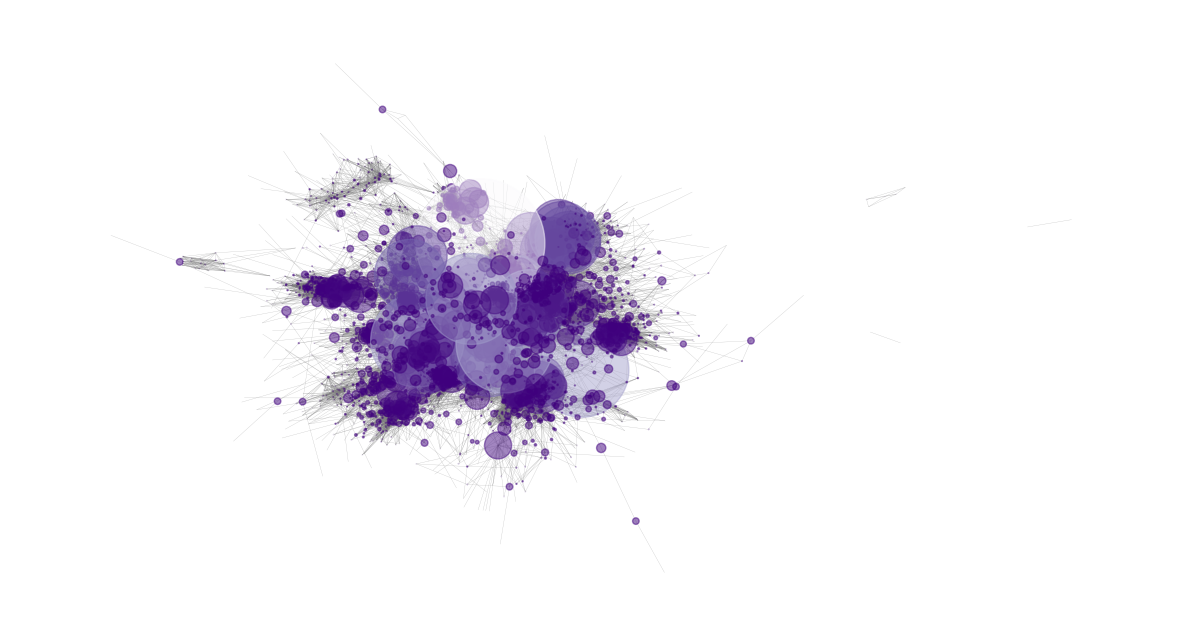

In [ ]:
values =[bet_cen.get(node)*50000 for node in G.nodes()]
pos = nx.spring_layout(G,iterations=15, seed=12)
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, cmap=plt.get_cmap('Purples_r'), node_color=values,
                 node_size=values,with_labels=False,edge_color="gray",width=0.2,alpha = 0.5)
plt.axis('off')

[(6207392, 0.1725645640056724),
 (3359851, 0.15443758920551148),
 (783214, 0.0975291202117271),
 (41716273, 0.09272687817377762),
 (17093617, 0.09073724589851986)]

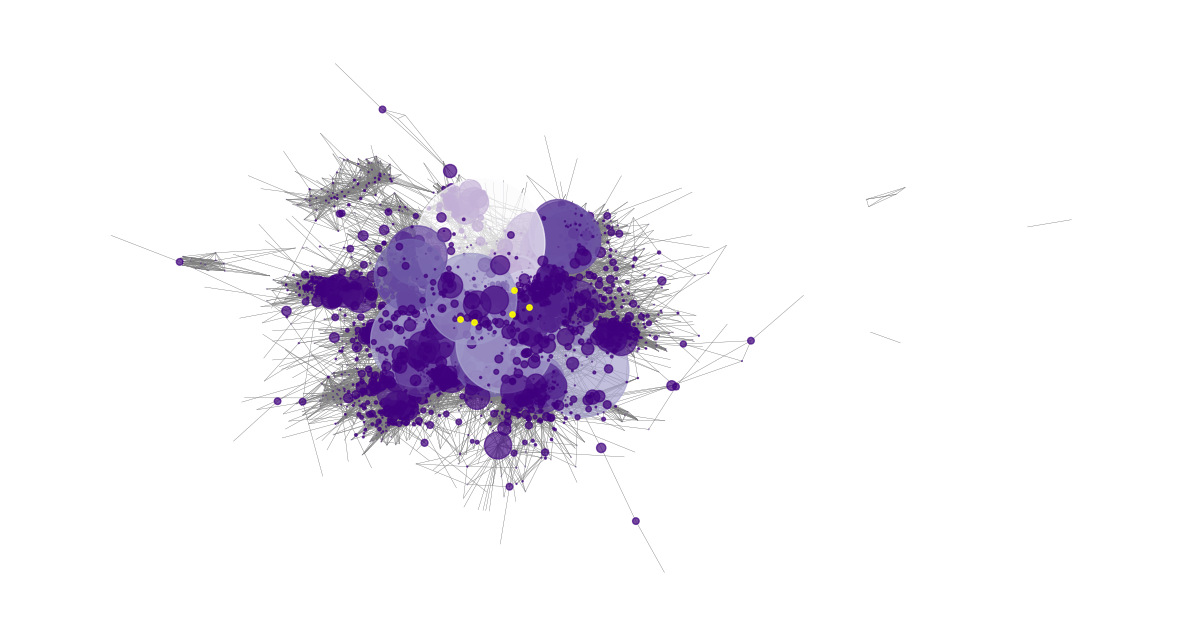

In [ ]:
#Identificando nodos mas cercanos
bet_items = bet_cen.items()
bet_items_sorted = sorted(clos_items, key = lambda item:item[1], reverse = True)
bet_cnt_sorted = {k:v for k,v in clos_items_sorted}
bet_important_nodes = list(clos_cnt_sorted)[:5]
#Grafico de nodos con mayor grado de cercanía
pos = nx.spring_layout(G,iterations=15, seed=12)
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, cmap=plt.get_cmap('Purples_r'), with_labels=False,
                 width=0.2,edge_color="gray",node_color=values,node_size=values,alpha = 0.7)
nx.draw_networkx(G, pos=pos, nodelist = bet_important_nodes, with_labels=False,
                 width=0.2,edge_color="gray",node_color="yellow",node_size=15,alpha = 0.9)
plt.axis('off')
sorted(bet_cen.items(), key=lambda x:x[1], reverse=True)[0:5]

Los 5 nodos señalados en color amarillo corresponden a los cinco usuarios de twitter con mayor oportunidades de actuar como intermediarios o puentes para difundir información entre diferentes partes de la red, porque tienen los mayor grados de centralidad de intermediación. Se destaca el usuario **3359851** como un gran influenciador porque se encuentra entre los que tienen mayor numero de conexiones, mayor numero de nodos cercanos y facilitador en la comunicación con otros usuarios

## Identificando comunidades en la red

In [ ]:
# Perform community detection
communities = nx.community.label_propagation_communities(G)
len(communities)

88

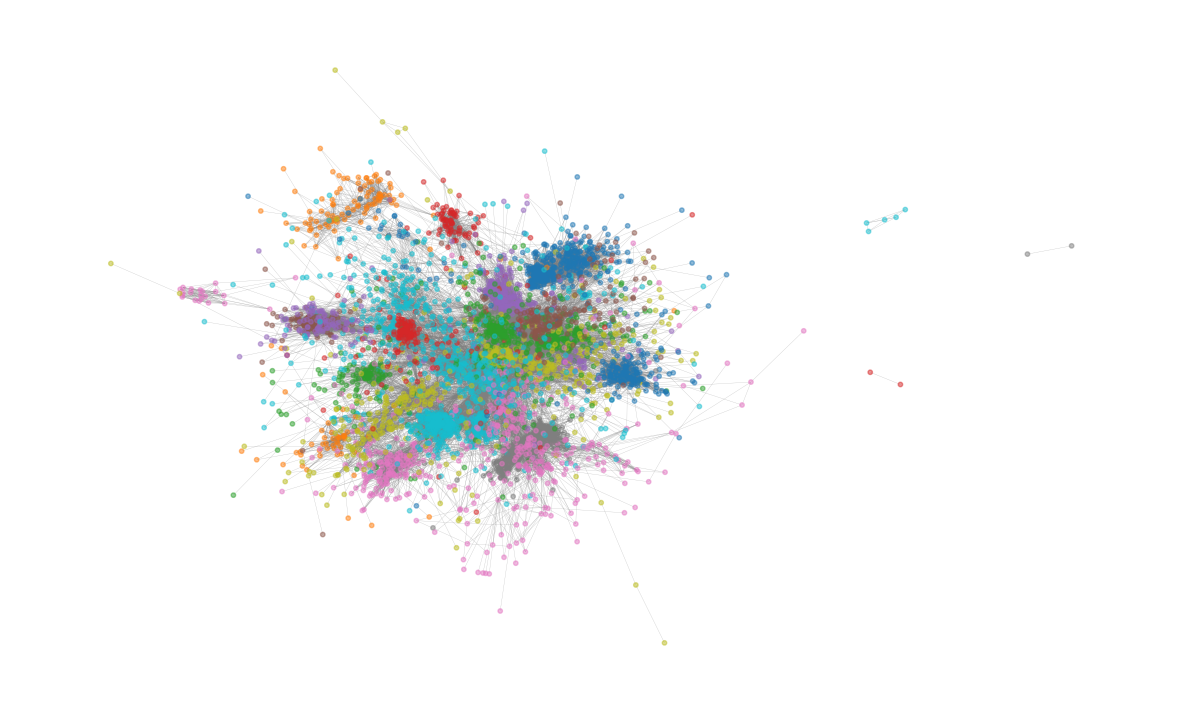

In [ ]:
part = community_louvain.best_partition(G)
values = [part.get(node) for node in G.nodes()]
plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(G, pos=pos, cmap=plt.get_cmap('tab10'), node_color=values,
                 node_size=10,with_labels=False,edge_color="gray",width=0.2,alpha = 0.5)

### Eliminar nodos no conectados a la red

In [ ]:
components = list(nx.connected_components(G))
# Find the largest connected component
largest_component = max(components, key=len)
# Create a new graph with only the nodes from the largest connected component
G1 = G.subgraph(largest_component)
# Print the nodes in the new graph
print(G1.nodes())
deg_cen = nx.degree_centrality(G1)

[214328887, 34428380, 17116707, 28465635, 380580781, 18996905, 221036078, 153460275, 107830991, 17868918, 151338729, 222261763, 19705747, 88323281, 19933035, 149538028, 158419434, 17434613, 153226312, 364971269, 100581193, 279787626, 113058991, 69592091, 187773078, 406628822, 262802533, 460282402, 280935165, 437804658, 27633075, 285312927, 131613362, 17675120, 394263193, 254839786, 204317520, 21548772, 67864340, 172883064, 270449528, 297801196, 8088112, 14925700, 124528830, 307458983, 160237722, 220368467, 54228724, 206923844, 103598216, 207594668, 21146135, 451250774, 314316607, 6581292, 31331740, 196327549, 225444667, 274153775, 35415466, 72818790, 324201646, 40981798, 430268163, 88097807, 276308596, 358775055, 15023872, 16870853, 70492333, 430313102, 299715516, 35359596, 276577539, 248883350, 157829215, 107511013, 22462180, 258140947, 200559228, 19493072, 123371682, 461410856, 31414569, 37699718, 117901353, 117674417, 231238695, 56860418, 43003845, 413275344, 259842341, 400689940, 2

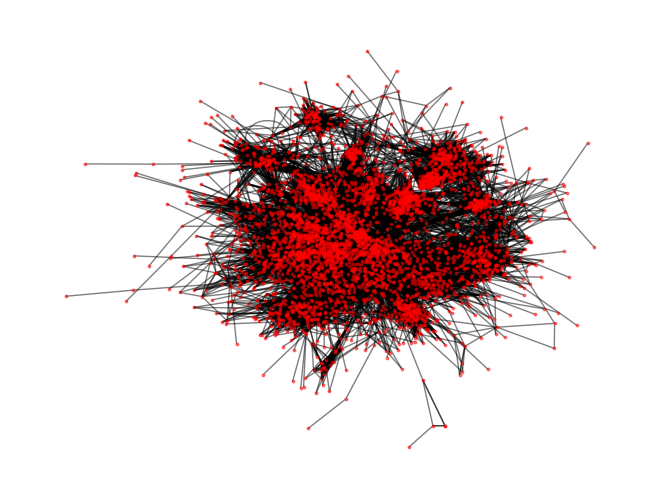

In [ ]:
layout = nx.spring_layout(G1,iterations=15, seed=12)
nx.draw(G1, pos = layout, node_color = "red", node_size = 3, alpha = 0.5)

In [ ]:
print('Number of nodes:', len(G1.nodes))
print('Number of edges:', len(G1.edges))
print('Average degree:', sum(dict(G1.degree).values()) / len(G1.nodes))
print(G1)  # to get the graph properties

Number of nodes: 4143
Number of edges: 57150
Average degree: 27.588703837798697
Graph with 4143 nodes and 57150 edges
